<a href="https://colab.research.google.com/github/merazlab/NLP-Project/blob/master/Problem02_01/Problem2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U torch==1.13.0 torchtext==0.14.0 torchdata==0.5.0
# Reload environment
exit()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 72.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.17.1
    Uninstalling torchtext-0.17.1:
      Successfully uninstalled torchtext-0.17.1
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.7.1
    Uninstalling

# RNN Classifier with LSTM Trained on Own Dataset (IMDB)

This notebook showing how to use an own CSV text dataset for training a simple RNN for sentiment classification (here: a binary classification problem with two labels, positive and negative) using LSTM (Long Short Term Memory) cells.

In [1]:
import time
import random
import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
import torchtext

torch.backends.cudnn.deterministic = True

## General Settings

In [2]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

VOCABULARY_SIZE = 20000
LEARNING_RATE = 0.005
BATCH_SIZE = 128
NUM_EPOCHS = 15
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

EMBEDDING_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 2

## Download Dataset

The following cells will download the IMDB movie review dataset (http://ai.stanford.edu/~amaas/data/sentiment/) for positive-negative sentiment classification in as CSV-formatted file:

In [3]:
!wget https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz

--2024-05-12 14:12:20--  https://github.com/rasbt/python-machine-learning-book-3rd-edition/raw/master/ch08/movie_data.csv.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch08/movie_data.csv.gz [following]
--2024-05-12 14:12:20--  https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch08/movie_data.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26521894 (25M) [application/octet-stream]
Saving to: ‘movie_data.csv.gz’

movie_data.csv.gz   100%[===================>]  25.29M  --.-KB/s    in 0.09s   

2

In [4]:
!gunzip -f movie_data.csv.gz

In [5]:
df = pd.read_csv('movie_data.csv')
df.head()

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


## Prepare Dataset with Torchdata and the new DataPipes API

In [6]:
from torchdata.datapipes.iter import IterableWrapper, FileOpener
datapipe = IterableWrapper(["movie_data.csv"])
datapipe = FileOpener(datapipe, mode='b')
datapipe = datapipe.parse_csv(skip_lines=1)

# Get the number of rows in dataset
N_ROWS = len(list(datapipe))  # 50000

# Split into train/val/test
train_dp, valid_dp, test_dp = datapipe.random_split(total_length=N_ROWS, weights={"train": 0.8, "valid": 0.1, "test": 0.1}, seed=0)

print(f'Num Train: {len(train_dp)}')
print(f'Num Validate: {len(valid_dp)}')
print(f'Num Test: {len(test_dp)}')

Num Train: 40000
Num Validate: 5000
Num Test: 5000


## Build the Vocabulary

Build the vocabulary based on the top `VOCABULARY_SIZE` words. **build_vocab_from_iterator()** collects the most frequent tokens from the iterator **yield_tokens(train_datapipe)**, and adds special tokens at the begginning w/o changing the order of supplied tokens.


In [7]:
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)

def get_vocab(train_datapipe):
    vocab = build_vocab_from_iterator(yield_tokens(train_datapipe), specials=["<UNK>", "<PAD>"], max_tokens=VOCABULARY_SIZE)
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

vocab = get_vocab(train_dp)
print("Vocabulary size: ", len(vocab))

Vocabulary size:  20000


PyTorch RNNs can deal with arbitrary lengths due to dynamic graphs, but padding is necessary for padding sequences to the same length in a given minibatch so we can store those in an array.

In [8]:
PADDING_VALUE=vocab['<PAD>']

text_transform = lambda x: [vocab[token] for token in tokenizer(x)]
label_transform = lambda x: 1 if x == '1' else 0

# Print out the output of text_transform
print("input to the text_transform:", "here is an example")
print("output of the text_transform:", text_transform("here is an example"))

input to the text_transform: here is an example
output of the text_transform: [135, 10, 41, 476]


**How do I convert an array of integers to the corresponding tokens?**

In [9]:
vocab_itos = vocab.get_itos()
vec_vocab_itos = np.vectorize(lambda x: vocab_itos[x])
vec_vocab_itos([1, 2, 3, 4, 5])

array(['<PAD>', 'the', '.', ',', 'and'], dtype='<U5')

## Define Data Loaders

In [10]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_batch(batch):
   text_list, label_list = [], []
   for (_text, _label) in batch:
        processed_text = torch.tensor(text_transform(_text))
        text_list.append(processed_text)
        label_list.append(label_transform(_label))
   return pad_sequence(text_list, padding_value=PADDING_VALUE).to(DEVICE), torch.tensor(label_list).to(DEVICE)

To group the texts with similar length together, like introduced in the legacy `BucketIterator` class, first of all, we randomly create multiple "pools", and each of them has a size of `batch_size * 100`. Then, we sort the samples within the individual pool by length. This idea can be implemented succintly through `batch_sampler` argument of PyTorch `Dataloader`. `batch_sampler` accepts 'Sampler' or Iterable object that yields indices of next batch. In the code below, we implemented a generator that yields batch of indices for which the corresponding batch of data is of similar length.

In [11]:
from torch.utils.data import Sampler, Dataset

# Create our own sampler, to ensure we function with multiple worker threads
# See https://discuss.pytorch.org/t/using-distributedsampler-in-combination-with-batch-sampler-to-make-sure-batches-have-sentences-of-similar-length/119824/3
class BatchSamplerSimilarLength(Sampler):
    def __init__(self, dataset, batch_size, indices=None, shuffle=True):
        self.batch_size = batch_size
        self.shuffle = shuffle
        # get the indices and length
        self.indices = [(i, len(tokenizer(s[0]))) for i, s in enumerate(dataset)]
        # if indices are passed, then use only the ones passed (for ddp)
        if indices is not None:
            self.indices = torch.tensor(self.indices)[indices].tolist()

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.indices)

        pooled_indices = []
        # create pool of indices with similar lengths
        for i in range(0, len(self.indices), self.batch_size * 100):
          pooled_indices.extend(sorted(self.indices[i:i + self.batch_size * 100], key=lambda x: x[1]))
        self.pooled_indices = [x[0] for x in pooled_indices]

        # Comment in for validation
        #self.pooled_lengths = [x[1] for x in pooled_indices]
        #print(self.pooled_lengths)
        #print(self.pooled_indices)

        # yield indices for current batch
        batches = [self.pooled_indices[i:i + self.batch_size] for i in
                   range(0, len(self.pooled_indices), self.batch_size)]

        if self.shuffle:
            random.shuffle(batches)
        for batch in batches:
            yield batch

    def __len__(self):
        return len(self.pooled_indices) // self.batch_size

In [12]:
train_dp_list = list(train_dp)
valid_dp_list = list(valid_dp)
test_dp_list = list(test_dp)

train_loader = DataLoader(train_dp_list,
                          batch_sampler=BatchSamplerSimilarLength(dataset = train_dp_list,
                                                                  batch_size=BATCH_SIZE),
                          collate_fn=collate_batch)
valid_loader = DataLoader(train_dp_list,
                          batch_sampler=BatchSamplerSimilarLength(dataset = valid_dp_list,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch)
test_loader = DataLoader(train_dp_list,
                          batch_sampler=BatchSamplerSimilarLength(dataset = test_dp_list,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=False),
                          collate_fn=collate_batch)

text_batch, label_batch = next(iter(train_loader))
print(text_batch.size())
print(label_batch.size())

torch.Size([163, 128])
torch.Size([128])


**Compute model accuracy on a dataloader**

Pass the train, valid or test dataloader


In [14]:
def compute_accuracy(model, data_loader, device):

    with torch.no_grad():

        correct_pred, num_examples = 0, 0

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum().to("cpu")

    return float(correct_pred)/num_examples * 100

**Train a model**

This is model- and dataloader-independent.

In [15]:
def train_model(model, num_epochs, train_loader,
                valid_loader, test_loader, optimizer,
                device, logging_interval=50,
                scheduler=None,
                scheduler_on='valid_acc'):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []

    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)

            # ## FORWARD AND BACK PROP
            logits = model(features)
            loss = torch.nn.functional.cross_entropy(logits, targets)
            optimizer.zero_grad()

            loss.backward()

            # ## UPDATE MODEL PARAMETERS
            optimizer.step()

            # ## LOGGING
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                      f'| Batch {batch_idx:04d}/{len(train_loader):04d} '
                      f'| Loss: {loss:.4f}')

        model.eval()
        with torch.no_grad():  # save memory during inference
            train_acc = compute_accuracy(model, train_loader, device=device)
            valid_acc = compute_accuracy(model, valid_loader, device=device)
            print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} '
                  f'| Train: {train_acc :.2f}% '
                  f'| Validation: {valid_acc :.2f}%')
            train_acc_list.append(train_acc)
            valid_acc_list.append(valid_acc)

        elapsed = (time.time() - start_time)/60
        print(f'Time elapsed: {elapsed:.2f} min')

        if scheduler is not None:

            if scheduler_on == 'valid_acc':
                scheduler.step(valid_acc_list[-1])
            elif scheduler_on == 'minibatch_loss':
                scheduler.step(minibatch_loss_list[-1])
            else:
                raise ValueError(f'Invalid `scheduler_on` choice.')


    elapsed = (time.time() - start_time)/60
    print(f'Total Training Time: {elapsed:.2f} min')

    test_acc = compute_accuracy(model, test_loader, device=device)
    print(f'Test accuracy {test_acc :.2f}%')

    return minibatch_loss_list, train_acc_list, valid_acc_list


**Plot training loss and accuracy**

In [16]:
import matplotlib.pyplot as plt

def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)


def plot_accuracy(train_acc_list, valid_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)


## Model

In [17]:
class LSTM(torch.nn.Module):

    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()

        self.embedding = torch.nn.Embedding(input_dim, embedding_dim)

        self.rnn = torch.nn.LSTM(embedding_dim,
                                 hidden_dim)

        self.fc = torch.nn.Linear(hidden_dim, output_dim)


    def forward(self, text):
        # text dim: [sentence length, batch size]
        embedded = self.embedding(text)
        # embedded dim: [sentence length, batch size, embedding dim]

        output, (hidden, cell) = self.rnn(embedded)
        # output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        hidden.squeeze_(0)
        # hidden dim: [batch size, hidden dim]

        output = self.fc(hidden)
        return output

## Train and plot the results

In [18]:
model = LSTM(input_dim=len(vocab),
             embedding_dim=EMBEDDING_DIM,
             hidden_dim=HIDDEN_DIM,
             output_dim=NUM_CLASSES # could use 1 for binary classification
)

model = model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=10,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    device=DEVICE,
    logging_interval=100)



Epoch: 001/010 | Batch 0000/0312 | Loss: 0.6977
Epoch: 001/010 | Batch 0100/0312 | Loss: 0.6824
Epoch: 001/010 | Batch 0200/0312 | Loss: 0.4978
Epoch: 001/010 | Batch 0300/0312 | Loss: 0.4309
Epoch: 001/010 | Train: 77.13% | Validation: 76.30%
Time elapsed: 0.82 min
Epoch: 002/010 | Batch 0000/0312 | Loss: 0.4783
Epoch: 002/010 | Batch 0100/0312 | Loss: 0.5511
Epoch: 002/010 | Batch 0200/0312 | Loss: 0.3628
Epoch: 002/010 | Batch 0300/0312 | Loss: 0.1842
Epoch: 002/010 | Train: 90.73% | Validation: 91.00%
Time elapsed: 1.66 min
Epoch: 003/010 | Batch 0000/0312 | Loss: 0.1531
Epoch: 003/010 | Batch 0100/0312 | Loss: 0.2187
Epoch: 003/010 | Batch 0200/0312 | Loss: 0.2298
Epoch: 003/010 | Batch 0300/0312 | Loss: 0.2039
Epoch: 003/010 | Train: 94.48% | Validation: 93.80%
Time elapsed: 2.47 min
Epoch: 004/010 | Batch 0000/0312 | Loss: 0.1773
Epoch: 004/010 | Batch 0100/0312 | Loss: 0.3271
Epoch: 004/010 | Batch 0200/0312 | Loss: 0.1340
Epoch: 004/010 | Batch 0300/0312 | Loss: 0.1501
Epoch: 

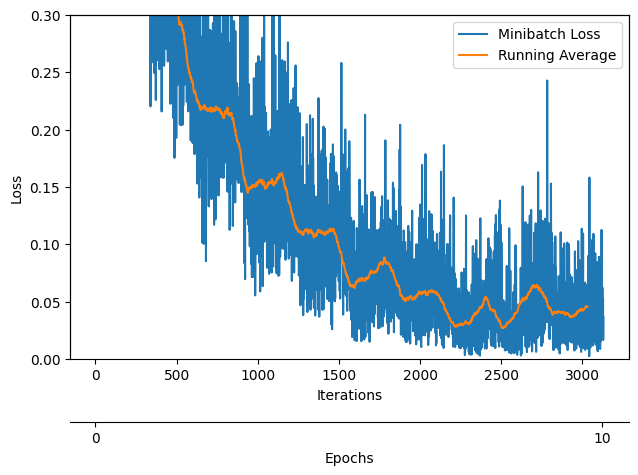

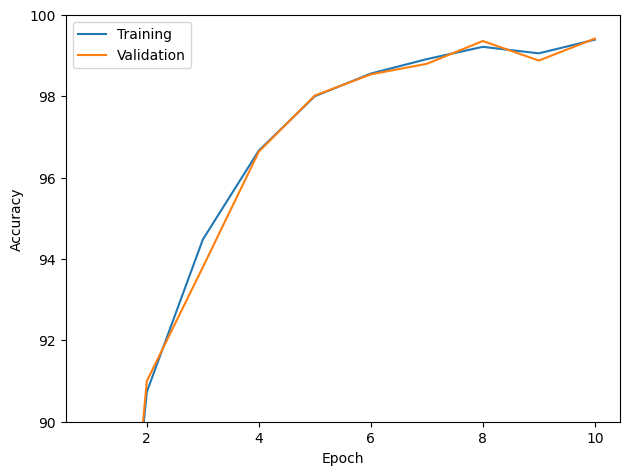

In [19]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.ylim([0, .3])
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([90, 100])
plt.show()

In [20]:
def predict_sentiment(model, sentence):

    model.eval()
    tokenized = tokenizer(sentence)
    indexed = [vocab[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(DEVICE)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = F.softmax(model(tensor), dim=1)
    return prediction.to("cpu").squeeze(dim=0).detach().numpy()

print('Probability positive:')
predict_sentiment(model, "This is such an awesome movie, I really love it!")[1]


Probability positive:


0.99806947

In [21]:
print('Probability negative:')
predict_sentiment(model, "I really hate this movie. It is really bad and sucks!")[0]

Probability negative:


0.99997544

### Refrence
STAT 453: Intro to Deep Learning @ UW-Madison (Spring 2021)

GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21  
